In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nqDataLoader as nq #data loading library
from keras.preprocessing import sequence
# np.random.seed(0)
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# from keras.utils import to_categorical

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [6]:
## importing the early stage dataset 
early_stage = pd.read_csv('GT_DataPD_MIT-CS2PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
early_stage["gt"] = early_stage["gt"].astype(int)
early_stage.head()

,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1
0,1000,1,27,79.0,184.5,0.107179,56.866667,1424946827.1000_001_014.csv
1,1001,1,16,96.5,189.0,0.056286,118.000000,1427279751.1001_001_014.csv
2,1002,0,5,140.0,158.0,0.039519,119.037037,1426676689.1002_001_014.csv
3,1004,1,22,83.5,191.5,0.034853,74.266667,1429866367.1004_001_014.csv
4,1005,1,17,68.0,150.0,0.048307,74.969697,1430134526.1005_001_014.csv


In [7]:
hit_time_series = []
for index, row in early_stage.iterrows():
    fileloc = row.file_1
    keyPressed, htArr, pressArr, releaseArr =  nq.getDataFiltHelper( "data_MIT-CS2PD/" + early_stage.loc[index]['file_1'])
    htArr =np.array(htArr)
    hit_time_series.append(htArr)

X1 = hit_time_series 

In [8]:
## importing the de-novo dataset 
de_novo = pd.read_csv('GT_DataPD_MIT-CS1PD.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values
print(len(de_novo))
de_novo["gt"] = de_novo["gt"].astype(int)
de_novo.head()

31


,pID,gt,updrs108,afTap,sTap,nqScore,typingSpeed,file_1,file_2
0,11,1,14.25,NaN,162.25,0.117543,189.372549,1402930351.011_001_014.csv,1403706430.011_003_014.csv
1,60,0,2.00,NaN,162.25,0.070350,60.533333,1402932300.060_001_014.csv,1403708258.060_003_014.csv
2,67,1,25.25,NaN,133.75,0.223411,54.333333,1401117235.067_001_014.csv,1401978395.067_003_014.csv
3,68,0,6.00,NaN,159.00,0.074973,71.800000,1401114972.068_001_014.csv,1401980765.068_003_014.csv
4,70,1,26.25,NaN,113.50,0.175751,39.614035,1404311419.070_001_014.csv,1404743687.070_003_014.csv


In [9]:
##using both files 
hit_time_series = []
for index, row in de_novo.iterrows():
    fileloc1 = row.file_1
    keyPressed, htArr1, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_1'])
    htArr1 = np.array(htArr1)
    keyPressed, htArr2, pressArr, releaseArr =  nq.getDataFiltHelper( 'data_MIT-CS1PD/' + de_novo.loc[index]['file_2'])
    htArr2 = np.array(htArr2)
    htArr =np.concatenate((htArr1,htArr2),axis =0)
    htArr=np.array(htArr)
    hit_time_series.append(htArr)
X2 = hit_time_series 

In [10]:
X = np.concatenate((X1,X2),axis=0)
y=  np.concatenate((early_stage['gt'],de_novo["gt"]),axis=0)
print(X.shape)
print(y)

(85,)
[1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 1 1 0]


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
flat_list = list(itertools.chain(*X))
value = sum(flat_list) / len(flat_list)
print(value)
X_padded =sequence.pad_sequences(X,dtype='float32',padding='post',maxlen=6000,value =1)

# X_padded = np.log(X_padded)

# sc = StandardScaler()
# X_padded = sc.fit_transform(X_padded)
# X_padded = np.reshape(X_padded,(85,6000,1))
# X_train,X_test,y_train,y_test = train_test_split(X_padded,y,test_size=0.17,stratify=y)


0.11633377817478088


In [22]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
def create_model(n_dense=50,dropout=0.5):
    # head 1
    inputs1 = Input(shape=(6000,1))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
#     # head 2
#     inputs2 = Input(shape=(6000,1))
#     conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(inputs2)
#     drop2 = Dropout(dropout)(conv2)
#     pool2 = MaxPooling1D(pool_size=2)(drop2)
#     flat2 = Flatten()(pool2)
    #head 3
    inputs3 = Input(shape=(6000,1))
    conv3 = Conv1D(filters= 64, kernel_size=5, activation='relu')(inputs3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
#     head 4
    inputs4 = Input(shape=(6000,1))
    conv4 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)
#     merge
    merged = concatenate([ flat1,flat3,flat4])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    drop5 = Dropout(0.1)(dense1)
    dense2 = Dense(n_dense, activation='relu')(drop5)
    outputs = Dense(1, activation='sigmoid')(dense2)
    model = Model(inputs=[inputs1,inputs3,inputs4], outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [13]:
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import StratifiedKFold
# # head 1
# inputs1 = Input(shape=(6000,1))
# conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
# drop1 = Dropout(0.5)(conv1)
# pool1 = MaxPooling1D(pool_size=2)(drop1)
# flat1 = Flatten()(pool1)
# # head 2
# inputs2 = Input(shape=(6000,1))
# conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
# drop2 = Dropout(0.5)(conv2)
# pool2 = MaxPooling1D(pool_size=2)(drop2)
# flat2 = Flatten()(pool2)
# # head 3
# inputs3 = Input(shape=(6000,1))
# conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
# drop3 = Dropout(0.5)(conv3)
# pool3 = MaxPooling1D(pool_size=2)(drop3)
# flat3 = Flatten()(pool3)
# # merge
# merged = concatenate([flat1, flat2, flat3])
# # interpretation
# dense1 = Dense(100, activation='relu')(merged)
# outputs = Dense(1, activation='sigmoid')(dense1)
# model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot_model(model, show_shapes=True, to_file='multichannel.png')

# model.fit([X_train,X_train,X_train], y_train, epochs=10, batch_size=50, verbose=1)
# _, accuracy = model.evaluate([X_test,X_test,X_test], y_test, batch_size=10, verbose=0)
# print(accuracy)

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import keras
# model = KerasClassifier(build_fn=create_model, verbose=2)


In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
n_folds = 85
skf = KFold(n_folds)
skf = skf.split(X_padded,y)

cv_score = []

for i, (train, test) in enumerate(skf):
    model2 =create_model()
    # currently keras doesn't have like model.reset(), so the easiest way
    # recompiling our model in every step of the loop see below more
    sc = StandardScaler()
    sc2 = MinMaxScaler()  
    X_train = X_padded[train]
#     X_train = sc.fit_transform(X_train)
    X_train = sc2.fit_transform(X_train)
    X_train = np.array(X_train)
    X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
    X_test = X_padded[test]
#     X_test = sc.transform(X_test)
    X_test = sc2.transform(X_test)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    print("Running Fold", i+1, "/", n_folds)
    model2.fit([X_train,X_train,X_train], y[train], epochs=10, batch_size=1)
    result = model2.evaluate([X_test,X_test,X_test], y[test])
    keras.backend.clear_session()
    # if we want only the accuracy metric
    cv_score.append(result[1])
    # we have to clear previous model to reset weights
    # currently keras doesn't have like model.reset()
   

print("\nMean accuracy of the crossvalidation: {}".format(np.mean(cv_score),np.std(cv_score)))

Running Fold 1 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 4.8246 - accuracy: 0.3810
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7542 - accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6569 - accuracy: 0.6190
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6029 - accuracy: 0.6786
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5422 - accuracy: 0.7381
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5095 - accuracy: 0.7976
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6535 - accuracy: 0.7262
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4959 - accuracy: 0.7857
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4636 - accuracy: 0.8571
Epoch 10/10
1/1 [==============================] - 0s 140ms/step - loss: 0.9177 - accuracy: 0.0000

84/84 [==============================] - 1s 8ms/step - loss: 0.7427 - accuracy: 0.3690
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7124 - accuracy: 0.4286
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.4524
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6885 - accuracy: 0.5238
Epoch 10/10
1/1 [==============================] - 0s 159ms/step - loss: 0.6739 - accuracy: 1.0000
Running Fold 9 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 3.8981 - accuracy: 0.5238
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.9367 - accuracy: 0.4881
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6986 - accuracy: 0.5476
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6957 - accuracy: 0.5595
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6737 - accuracy: 0.5714
Epoch 6/10

Running Fold 16 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 2.8044 - accuracy: 0.5357
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7327 - accuracy: 0.5357
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6130 - accuracy: 0.6310
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6101 - accuracy: 0.7024
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.9849 - accuracy: 0.6190
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4742 - accuracy: 0.7381
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5009 - accuracy: 0.7500
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6357 - accuracy: 0.8095
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6951 - accuracy: 0.7024
Epoch 10/10
1/1 [==============================] - 0s 158ms/step - loss: 0.1641 - accuracy: 1.000

84/84 [==============================] - 1s 8ms/step - loss: 0.5784 - accuracy: 0.6905
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5435 - accuracy: 0.7381
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5031 - accuracy: 0.7976
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4980 - accuracy: 0.8452
Epoch 10/10
1/1 [==============================] - 0s 167ms/step - loss: 0.0105 - accuracy: 1.0000
Running Fold 24 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 5.8870 - accuracy: 0.4762
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7721 - accuracy: 0.5833
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7137 - accuracy: 0.6310
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7216 - accuracy: 0.6310
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6898 - accuracy: 0.5476
Epoch 6/1

1/1 [==============================] - 0s 173ms/step - loss: 1.5650 - accuracy: 0.0000e+00
Running Fold 31 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 3.0438 - accuracy: 0.4405
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6984 - accuracy: 0.5476
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7318 - accuracy: 0.5833
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7048 - accuracy: 0.5833
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6013 - accuracy: 0.6429
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5180 - accuracy: 0.7381
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4381 - accuracy: 0.8690
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.3948 - accuracy: 0.8810
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.3235 - accuracy: 0.8929
Epoch 

84/84 [==============================] - 1s 8ms/step - loss: 0.6437 - accuracy: 0.6429
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4965 - accuracy: 0.7500
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4645 - accuracy: 0.7857
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4902 - accuracy: 0.7500
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4349 - accuracy: 0.7738
Epoch 10/10
1/1 [==============================] - 0s 162ms/step - loss: 0.0083 - accuracy: 1.0000
Running Fold 39 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 5.5624 - accuracy: 0.5357
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7435 - accuracy: 0.6190
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7667 - accuracy: 0.5714
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6607 - accuracy: 0.6905
Epoch 5/1

1/1 [==============================] - 0s 162ms/step - loss: 1.4080 - accuracy: 0.0000e+00
Running Fold 46 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 3.2305 - accuracy: 0.4881
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7472 - accuracy: 0.4167
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7733 - accuracy: 0.6667
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6408 - accuracy: 0.6786
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5695 - accuracy: 0.7143
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.8687 - accuracy: 0.6310
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7262 - accuracy: 0.6786
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5736 - accuracy: 0.7262
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.3258 - accuracy: 0.8810
Epoch 

84/84 [==============================] - 1s 8ms/step - loss: 0.6861 - accuracy: 0.6905
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6459 - accuracy: 0.6071
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5536 - accuracy: 0.7143
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7027 - accuracy: 0.7143
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5321 - accuracy: 0.7857
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4582 - accuracy: 0.7738
Epoch 10/10
1/1 [==============================] - 0s 158ms/step - loss: 0.1872 - accuracy: 1.0000
Running Fold 54 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 9.5550 - accuracy: 0.5476
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 1.3883 - accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.9277 - accuracy: 0.5357
Epoch 4/1

84/84 [==============================] - 1s 8ms/step - loss: 0.4961 - accuracy: 0.7619
Epoch 10/10
1/1 [==============================] - 0s 168ms/step - loss: 0.3857 - accuracy: 1.0000
Running Fold 61 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 4.4155 - accuracy: 0.5952
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7826 - accuracy: 0.5000
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.9224 - accuracy: 0.5238
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6940 - accuracy: 0.5595
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7667 - accuracy: 0.6071
Epoch 6/10
84/84 [==============================] - 1s 7ms/step - loss: 0.7476 - accuracy: 0.5476
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5961 - accuracy: 0.7024
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6777 - accuracy: 0.6548
Epoch 9/1

84/84 [==============================] - 1s 8ms/step - loss: 0.7262 - accuracy: 0.5714
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6126 - accuracy: 0.7381
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6926 - accuracy: 0.6310
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7202 - accuracy: 0.6667
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.7156 - accuracy: 0.6310
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5449 - accuracy: 0.7500
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.4911 - accuracy: 0.7143
Epoch 10/10
1/1 [==============================] - 0s 174ms/step - loss: 1.0045 - accuracy: 0.0000e+00
Running Fold 69 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 6.3920 - accuracy: 0.5119
Epoch 2/10
84/84 [==============================] - 1s 8ms/step - loss: 0.8731 - accuracy: 0.5238
Epoch

84/84 [==============================] - 1s 8ms/step - loss: 0.6764 - accuracy: 0.6667
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5992 - accuracy: 0.7143
Epoch 10/10
1/1 [==============================] - 0s 164ms/step - loss: 1.1019 - accuracy: 0.0000e+00
Running Fold 76 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 4.1535 - accuracy: 0.5357
Epoch 2/10
84/84 [==============================] - 1s 7ms/step - loss: 0.7025 - accuracy: 0.4405
Epoch 3/10
84/84 [==============================] - 1s 7ms/step - loss: 0.7770 - accuracy: 0.4881
Epoch 4/10
84/84 [==============================] - 1s 7ms/step - loss: 0.7413 - accuracy: 0.4167
Epoch 5/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4286
Epoch 6/10
84/84 [==============================] - 1s 7ms/step - loss: 0.9053 - accuracy: 0.5833
Epoch 7/10
84/84 [==============================] - 1s 7ms/step - loss: 0.6823 - accuracy: 0.5833
Epoch

84/84 [==============================] - 1s 8ms/step - loss: 0.8538 - accuracy: 0.4762
Epoch 3/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6237 - accuracy: 0.6548
Epoch 4/10
84/84 [==============================] - 1s 8ms/step - loss: 0.9218 - accuracy: 0.5833
Epoch 5/10
84/84 [==============================] - 1s 7ms/step - loss: 0.6924 - accuracy: 0.6667
Epoch 6/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6648 - accuracy: 0.7143
Epoch 7/10
84/84 [==============================] - 1s 8ms/step - loss: 0.6695 - accuracy: 0.6786
Epoch 8/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5706 - accuracy: 0.7262
Epoch 9/10
84/84 [==============================] - 1s 8ms/step - loss: 0.5667 - accuracy: 0.7381
Epoch 10/10
1/1 [==============================] - 0s 308ms/step - loss: 0.2732 - accuracy: 1.0000
Running Fold 84 / 85
Epoch 1/10
84/84 [==============================] - 1s 8ms/step - loss: 2.1367 - accuracy: 0.4762
Epoch 2/1

In [16]:
cv_score

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0]

Epoch 1/5
68/68 [==============================] - 1s 8ms/step - loss: 0.3391 - accuracy: 0.8824
Epoch 2/5
68/68 [==============================] - 1s 8ms/step - loss: 0.6717 - accuracy: 0.8824
Epoch 3/5
68/68 [==============================] - 1s 8ms/step - loss: 0.1894 - accuracy: 0.9559
Epoch 4/5
68/68 [==============================] - 1s 8ms/step - loss: 0.1654 - accuracy: 0.9706
Epoch 5/5
68/68 [==============================] - 1s 8ms/step - loss: 0.1158 - accuracy: 0.9559


C:\Users\micoa\anaconda3\envs\classifiertest\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 413ms/step - loss: 0.6973 - accuracy: 0.4706
0.47058823704719543


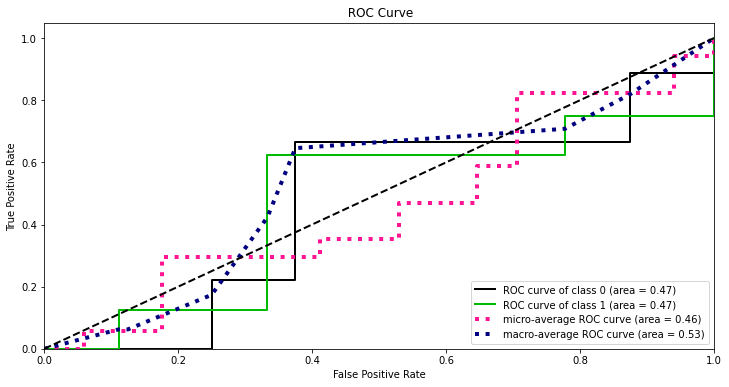

In [17]:
import scikitplot as skplt
model3 =create_model()
X_train,X_test,y_train,y_test = train_test_split(X_padded,y,test_size = 0.2,stratify=y)
X_train = sc.fit_transform(X_train)
X_train = sc2.fit_transform(X_train)
X_train = np.array(X_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = sc.transform(X_test)
X_test = sc2.transform(X_test)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
model2.fit([X_train,X_train,X_train], y_train, epochs=5, batch_size=1)
Y_test_probs = model3.predict([X_test,X_test,X_test])
y_test_probs_minus = [1-x for x in Y_test_probs]
y_proba = np.concatenate((y_test_probs_minus,Y_test_probs),axis = 1)
skplt.metrics.plot_roc_curve(y_test, y_proba,
                       title=" ROC Curve", figsize=(12,6));

result = model3.evaluate([X_test,X_test,X_test], y_test)
print(result[1])
keras.backend.clear_session()

In [18]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, to_file='multichannel.png')

In [19]:
cv_scores_total = [0.7058823704719543, 1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,0.66,0.8888888955116272, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
print(np.mean(cv_scores_total))
print(np.std(cv_scores_total))

0.9813692816495895
0.07081078853002026


{'whiskers': [<matplotlib.lines.Line2D at 0x24cd3539130>,
 'caps': [<matplotlib.lines.Line2D at 0x24cd3539c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x24cc5dbee20>],
 'medians': [<matplotlib.lines.Line2D at 0x24cd3539b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x24cc61c6340>],
 'means': []}

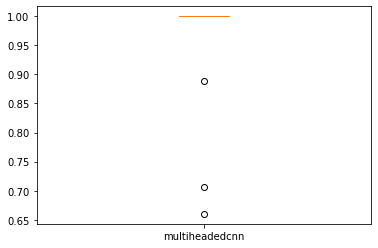

In [20]:
plt.boxplot([cv_scores_total], notch=None, vert=None, patch_artist=None, widths=None,labels=['multiheadedcnn'])

In [21]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import GridSearchCV
# param_grid={
#         'batch_size':[10,20,30], 
#         'epochs':[20,30],
#         'dropout':[0.3,0.4,0.5,0.6],
#         'n_dense' :[50,100,150]
           
#         }
# grid = GridSearchCV(estimator=model, param_grid=param_grid,pre_dispatch=6, cv=StratifiedKFold(5))
# grid_result = grid.fit([X_padded,X_padded,X_padded], y)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
